<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [2.2 Campus SEIR Modeling](https://jckantor.github.io/CBE40455-2020/02.02-Campus-SEIR-modeling.html) | [Contents](toc.html) | [2.10 Agent based model for control of COVID-19 on a college campus](https://jckantor.github.io/CBE40455-2020/02.10-Agent-based-campus-covid-model.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/02.03-Campus-reopening.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/02.03-Campus-reopening.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.3 Campus Re-opening Model

Following Paltiel, et al. (2020)



### 2.3.1 Active transmission and testing pool. 

This pool consists of individuals in the campus population subject to testing and the transmission of virus.

* $U$ uninfected, susceptible individuals
* $E$ exposed, asymptomatic, non-infectious
* $A$ infected, asymptomatic

\begin{align*}
\frac{dU}{dt} & = -\beta U \frac{A}{U + E + A} - \tau (1-S_p) U  + \mu F_p - x(t) \\
\frac{dE}{dt} & =  \beta U \frac{A}{U + E + A} - \theta E + x(t) \\
\frac{dA}{dt} & = \theta E - (\sigma + \rho + \tau S_e)A
\end{align*} 


### 2.3.2 Isolation pool

* $S$ infected, symptomatic with a true positive test result.
* $T_p$ infected, asymptomatic with a true positive test result
* $F_p$ uninfectd with a false positive result.

\begin{align*}
\frac{dF_p}{dt} & = -\mu F_p + \tau(1-S_p) U \\
\frac{dT_p}{dt} & = -(\sigma + \rho) T_p + \tau S_e A\\
\frac{dS}{dt} & = -(\rho + \delta)S + \sigma (T_p + A)
\end{align*} 

### 2.3.3 Removed pool

* $R$ recovered. These individuals assumed to be immune for the remainder of the simulation, and not returned to the campus population.
* $D$ dead.

\begin{align*}
\frac{dR}{dt} & =  \rho (T_p + A + S)\\\
\frac{dD}{dt} & = \delta S
\end{align*} 

### 2.3.4 Parameter estimates

Given:

* $\rho$ recovery rate 
* $R_t$ basic reproductive number for asymptomatic transmission 
* $p_{si}$ probability that an infected individual will become symptomatic.




#### 2.3.4.1 Odds of becoming symptomatic if infected

Based on the compartmental relationships and rates, the probability of symptom development for infected individuals is given by

$$p_{si} = \frac{\sigma}{\sigma + \rho}$$

Inverting this relationship

$$\sigma = \frac{p_{si}}{1 - p_{si}}\rho$$

where $\frac{p_{si}}{1 - p_{si}}$ is the 'odds' that an infected individual becomes symptomatic.


#### 2.3.4.2 Effective reproductive number with isolation of symptomatic individuals

For an initially uninfected population with no testing regime, where transmission is solely due to non-isolated, asymptomatic individuals, the effective reproductive number is

$$R_t = \frac{\beta}{\sigma + \rho}$$

Expressed in terms of recovery rate and probability of becoming symptomatic

$$R_t = \frac{\beta}{\rho}(1 - p_{si})$$

#### 2.3.4.3 Testing threshold

With a testing regime, for effective herd immunity requires

$$\beta \leq \sigma + \rho + \tau S_e $$

where $\tau$ is the testing rate and $S_e$ is the test sensitivity.  With some manipulation using the above relationships, the testing treshhold becomes

$$\tau S_e \geq \frac{(R_t - 1) \rho}{1 - p_{si}}$$

or 

$$\frac{1}{\tau} \leq S_e \left(\frac{1 - p_{si}}{R_t - 1}\right)\frac{1}{\rho} $$

#### 2.3.4.4 Parameter values

| parameter | value |
| :--: | :--: |
| $p_{si}$ | 0.3 |
| $R_t$ | [1.5, 2.5, 3.5] |
| $\frac{1}{\rho}$ | 14 d |
| $S_e$ | 0.7 |


t

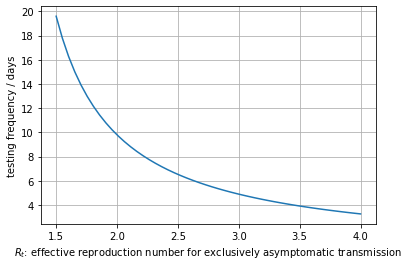

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Rt = np.linspace(1.5, 4.0)
Se = 0.7
rho = 1/14.0
psi = 0.3

tau = (Rt - 1)*rho/(1 - psi)
plt.plot(Rt, 1.0/tau)

plt.xlabel('$R_t$: effective reproduction number for exclusively asymptomatic transmission')
plt.ylabel('testing frequency / days')
plt.grid(True)

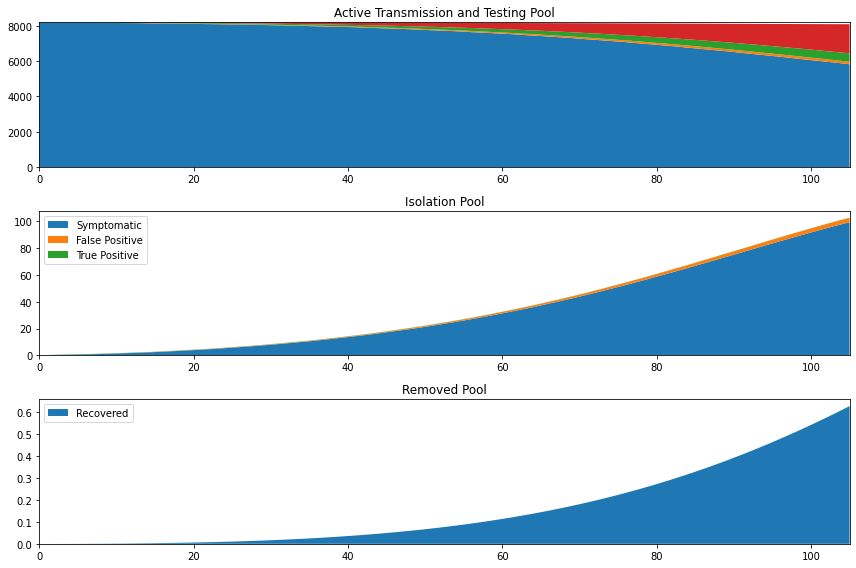

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

# time horizon in days
d = 15 * 7   

# disease dynamics
Rt = 1.5
theta = 1/3.0       # 1/incubation time in days
rho = 1.0/14.0      # 1/time to recovery in days
mu = 1.0/1.0        # 1/time to false-postive return in days
p_si = 0.20        # probability of symptoms given infection
p_fs = 0.0005      # probability of fataility given symptoms

sigma = rho * p_si / (1 - p_si)      # rate of symptom development
beta = (sigma + rho)*Rt
delta = rho * (p_fs/p_si) / (1 - (p_fs/p_si))

# testing protocols
Sp = 0.98       # test specificity
Se = 0.70       # test sensitivity
tau = 1000        # testing period

# population parameters
x = 10.0        # weekly exogeneous infections
y = 10.0
IC = [8200-y, 0, y, 0, 0, 0, 0, 0]

# SEIR model differential equations.
def deriv(t, X):
    U, E, A, S, Tp, Fp, R, D = X
    exog = x*((t + 1) % 7 < 1)
    dU = -beta*U*A/(U + E + A + R) - (1 - Sp)*U/tau + mu*Fp - exog
    dE = beta*U*A/(U + E + A + R) - theta*E + exog
    dA = theta*E - (sigma + rho + Se/tau)*A
    dS = -(rho + delta)*S + sigma*(Tp + A)
    dTp = -(sigma + rho)*Tp + Se*A/tau
    dFp = -mu*Fp + (1 - Sp)*U/tau
    dR = rho*(Tp + S + A)
    dD = delta*S
    return np.array([dU, dE, dA, dS, dTp, dFp, dR, dD,])

t = np.linspace(0, d, 10*d + 1)
soln = solve_ivp(deriv, [0, max(t)], IC, t_eval = t, atol=1e-8, rtol=1e-8)
U, E, A, S, Tp, Fp, R, D = soln.y

fix, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].stackplot(t, U, E, A, R)
ax[0].set_ylim(0, sum(IC))
ax[0].set_title('Active Transmission and Testing Pool')

ax[1].stackplot(t, S, Tp, Fp)
ax[1].legend(['Symptomatic', 'False Positive', 'True Positive'], loc="upper left")
ax[1].set_title('Isolation Pool')

ax[2].stackplot(t, D)
ax[2].set_title('Removed Pool')
ax[2].legend(['Recovered', 'Dead'], loc="upper left")

for a in ax:
    a.set_xlim(0, d)

plt.tight_layout()

<!--NAVIGATION-->
< [2.2 Campus SEIR Modeling](https://jckantor.github.io/CBE40455-2020/02.02-Campus-SEIR-modeling.html) | [Contents](toc.html) | [2.10 Agent based model for control of COVID-19 on a college campus](https://jckantor.github.io/CBE40455-2020/02.10-Agent-based-campus-covid-model.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/02.03-Campus-reopening.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/02.03-Campus-reopening.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>